In [1]:
import pandas as pd
import sys
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sys.path.insert(0,"..")
bremen_trips = pd.read_csv("../data/processed/trips_weather.csv", index_col=0)
bremen_trips = bremen_trips.sort_values(by=['start_time'], ascending=True)
bremen_trips["start_time"] = pd.to_datetime(bremen_trips["start_time"])

In [3]:

for col in ['start_time']:
    bremen_trips['month'] = pd.DatetimeIndex(bremen_trips['start_time']).month
    bremen_trips['booking_date'] = bremen_trips.start_time.dt.date
    bremen_trips['weekdays'] = pd.DatetimeIndex(bremen_trips['start_time']).weekday

In [4]:
bremen_trips['duration_min'] = bremen_trips['duration_sec']/60
data_raw =bremen_trips

In [5]:
data_raw['hour'] = data_raw['start_time'].dt.hour
data_raw['min'] = data_raw['start_time'].dt.minute
data_raw['day_of_month'] = data_raw['start_time'].dt.day
data_raw.drop(axis = 1, columns = 'start_time', inplace=True)

In [6]:
for col in data_raw.columns:
    pct_missing = np.mean(data_raw[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

identification - 0.0%
end_time - 0.0%
duration_sec - 0.0%
start_lng - 0.0%
start_lat - 0.0%
end_lng - 0.0%
end_lat - 0.0%
start_place - 0.0%
end_place - 0.0%
start_plz - 0.0%
end_plz - 0.0%
temp_2m - 0.0%
humidity_2m - 0.0%
dew_point_2m - 0.0%
max_at_2m - 0.0%
mean_speed_h/s - 0.0%
direction_degree_x - 0.0%
max_m/s - 0.0%
min_mean_m/s - 0.0%
max_mean_m/s - 0.0%
direction_degree_y - 0.0%
min - 0.0%
month - 0.0%
booking_date - 0.0%
weekdays - 0.0%
duration_min - 0.0%
hour - 0.0%
day_of_month - 0.0%


In [7]:
data_raw.drop(columns=["identification", "end_time", "end_lng", "end_lat", "end_place", "end_plz", "booking_date"], inplace=True)

In [29]:
data_raw.corrwith(data_raw['duration_min'])[:60].sort_values(ascending=False)

duration_min          1.000000
duration_sec          1.000000
start_plz             0.032302
start_place           0.016068
start_lat             0.014783
max_mean_m/s          0.011748
max_m/s               0.011627
mean_speed_h/s        0.011497
min_mean_m/s          0.010279
direction_degree_y    0.002629
direction_degree_x    0.002391
day_of_month          0.001005
start_lng            -0.002108
humidity_2m          -0.003819
min                  -0.004548
temp_2m              -0.008943
max_at_2m            -0.009031
weekdays             -0.012378
dew_point_2m         -0.014040
hour                 -0.018113
month                -0.029515
dtype: float64

It is evident, that almost none of the features correlates to the trip duration ( All below 5%). Thus we could conclude already that it is not possible to predict. Let's look at what we get anyways.

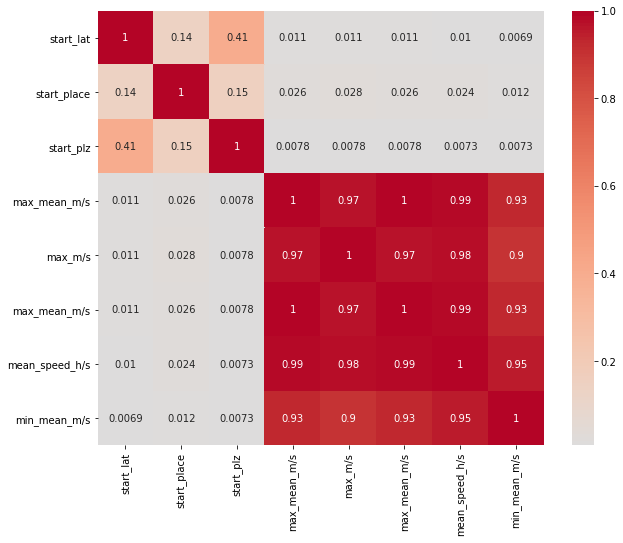

In [42]:
#Using Pearson Correlation

plt.figure(figsize=(10,8))
cor = data_raw[['start_lat','start_place','start_plz','max_mean_m/s','max_m/s','max_mean_m/s','mean_speed_h/s','min_mean_m/s']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm, center=0)
plt.show()

In [43]:
#X = data_raw.drop(columns={'duration_min','duration_sec'})
X = data_raw[['start_plz','start_place', 'max_mean_m/s']]
y = data_raw['duration_min']

In [44]:
from sklearn.model_selection import train_test_split


X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=False)

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [46]:
poly = PolynomialFeatures(1)
X_train_poly = poly.fit_transform(X_train)

In [47]:
lin = LinearRegression(normalize =True)

In [48]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.0013563157203143605

In [49]:
X_val_poly = poly.fit_transform(X_val)
lin.score(X_val_poly,y_val)

0.0011267635248572994

## Try with Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor


In [51]:
rf = RandomForestRegressor(criterion='mse',random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [52]:
rf.score(X_train, y_train)

0.2539423124371013

### Performing grid search to optimize hyperparameters

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestRegressor(criterion='mse')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='r2', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [54]:
# extract parameters
n_estimator, depth = perform_grid_search(X_val, y_val)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[-0.05159549 -0.04434743 -0.03762914 -0.02788285 -0.02461117 -0.02095109
 -0.02002546 -0.06195614 -0.0473527  -0.04084531 -0.03133458 -0.02793594
 -0.02386605 -0.02227218 -0.09575582 -0.0483158  -0.04302389 -0.03604356
 -0.03284433 -0.02844022 -0.02695153 -0.11910864 -0.05973438 -0.0509563
 -0.04566646 -0.04124778 -0.03867691 -0.03709713 -0.18835786 -0.09848918
 -0.09018725 -0.08659245 -0.08383061 -0.08033191 -0.07891818]
512 2 42


### Train model with optimized hyperparameters

In [55]:
rf = RandomForestRegressor(criterion='mse', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=512, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Evaluation

In [56]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))
print('Valiation accuracy: ' + str(rf.score(X_val, y_val)))

Training accuracy: 0.01371525190898193
Valiation accuracy: 0.004037422667085289


In [57]:
y_pred = rf.predict(X_train)

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_absolute_error(y_train, y_pred)

572.5721580641064

## Apply to test set


In [59]:
X_train = X_train.append(X_val)
y_train = y_train.append(y_val)

In [60]:
rf = RandomForestRegressor(criterion='mse', n_estimators=n_estimator, max_depth=depth)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=512, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [61]:
print('Training accuracy: ' + str(rf.score(X_train, y_train)))

Training accuracy: 0.011652843573006775


In [62]:
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Test accuracy: -0.006915174245320621
